In [358]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
# reading
#read text file into a Dataframe
df = pd.read_csv("Mushroom.csv")
test_df = pd.read_csv("Mushroom_test.csv")

In [359]:
#df.head()

In [360]:
df.shape

(6499, 8)

In [361]:
df.sample(5)

,cap.shape,cap.color,bruises,stalk.color.above.ring,stalk.color.below.ring,population,Id,poisonous
4240,f,e,True,p,p,v,6993,0
5612,x,g,True,w,p,y,1828,0
931,x,y,True,w,w,s,5758,0
1553,k,n,False,p,w,v,2944,1
2942,f,w,True,w,w,v,2435,1


In [362]:
df.isnull().sum()   #df.isna().sum()

cap.shape                 0
cap.color                 0
bruises                   0
stalk.color.above.ring    0
stalk.color.below.ring    0
population                0
Id                        0
poisonous                 0
dtype: int64

In [363]:
df.duplicated().sum()

0

In [364]:
# Change index to Id, since df['Id'].is_unique # is True
df = df.set_index('Id')
test_df =test_df.set_index('Id') 

print([df.shape[0], test_df.shape[0]])

[6499, 1625]


In [365]:
df.corr()

,bruises,poisonous
bruises,1.000000,-0.493621
poisonous,-0.493621,1.000000


In [366]:
df['poisonous'].value_counts()

0    3342
1    3157
Name: poisonous, dtype: int64

<AxesSubplot:ylabel='poisonous'>

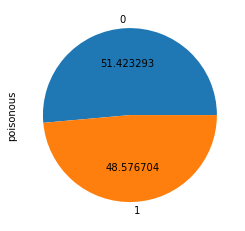

In [367]:
df['poisonous'].value_counts().plot(kind='pie',autopct = '%2f')

<AxesSubplot:xlabel='poisonous', ylabel='bruises'>

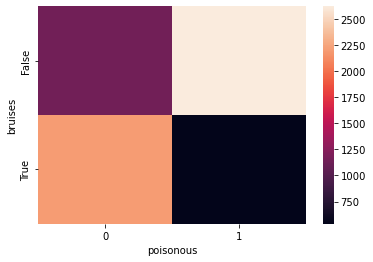

In [368]:
sns.heatmap(pd.crosstab(df['bruises'],df['poisonous']))

In [369]:
# X and y creation
y = df.pop("poisonous")
X = df

# data splitting
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123000)

In [370]:
#X_train

In [371]:
#Data inspection
X.isna().sum()

cap.shape                 0
cap.color                 0
bruises                   0
stalk.color.above.ring    0
stalk.color.below.ring    0
population                0
dtype: int64

In [372]:
#Automated approach
# import
from sklearn.preprocessing import OneHotEncoder
# select categorical and numerical column names
X_cat_columns = X.select_dtypes(exclude="number").copy().columns

# create categorical pipeline, with the SimpleImputer(fill_value="N_A") and the OneHotEncoder
categoric_pipe = make_pipeline(
    OneHotEncoder(handle_unknown='ignore')
)

from sklearn.compose import ColumnTransformer

preprocessor = ColumnTransformer(
    transformers=[
        ("cat_pipe", categoric_pipe, X_cat_columns)
    ],remainder = 'passthrough'
)

In [373]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler(with_mean=False)
full_pipeline = make_pipeline(preprocessor,
                              scaler,
                              DecisionTreeClassifier())


In [374]:
full_pipeline.fit(X_train, y_train) #training the machine

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat_pipe',
                                                  Pipeline(steps=[('onehotencoder',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  Index(['cap.shape', 'cap.color', 'bruises', 'stalk.color.above.ring',
       'stalk.color.below.ring', 'population'],
      dtype='object'))])),
                ('standardscaler', StandardScaler(with_mean=False)),
                ('decisiontreeclassifier', DecisionTreeClassifier())])

In [375]:
# training accuracy
y_train_pred = full_pipeline.predict(X_train)
accuracy_score(y_train, y_train_pred)

0.9597999615310636

In [376]:
# testing accuracy
y_test_pred = full_pipeline.predict(X_test)

accuracy_score(y_test, y_test_pred)  

0.9653846153846154

In [377]:
#Grid search CV
from sklearn.model_selection import GridSearchCV

full_pipeline = make_pipeline(preprocessor, 
                              DecisionTreeClassifier())

param_grid = {
    #"columntransformer__num_pipe__simpleimputer__strategy":["mean", "median"],
    "decisiontreeclassifier__max_depth": range(2, 14, 2),
    "decisiontreeclassifier__min_samples_leaf": range(3, 12, 2)
}

search = GridSearchCV(full_pipeline,
                      param_grid,
                      cv=5,
                      scoring='recall',
                      verbose=1
                     )

search.fit(X_train, y_train)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('columntransformer',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(handle_unknown='ignore'))]),
                                                                         Index(['cap.shape', 'cap.color', 'bruises', 'stalk.color.above.ring',
       'stalk.color.below.ring', 'population'],
      dtype='object'))])),
                                       ('decisiontreeclassifier',
                                        DecisionTreeClassifier())]),
             param_grid={'decisiontreeclassifier__max_depth': range(2, 14, 2),
                         'decisiontreeclassifier__min_samples_leaf': range(3, 12, 2)},
             scoring='recall', verbose=1)

In [378]:
search.best_params_

{'decisiontreeclassifier__max_depth': 8,
 'decisiontreeclassifier__min_samples_leaf': 3}

In [379]:
search.best_score_   

0.9829475090366181

In [380]:
# testing accuracy after GridsearchCV
y_test_pred = search.predict(X_test)

accuracy_score(y_test, y_test_pred)

0.9523076923076923

In [381]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_test, y_test_pred, labels=None, sample_weight=None, normalize=None)

array([[610,  54],
       [  8, 628]], dtype=int64)

In [382]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.99      0.92      0.95       664
           1       0.92      0.99      0.95       636

    accuracy                           0.95      1300
   macro avg       0.95      0.95      0.95      1300
weighted avg       0.95      0.95      0.95      1300



## Using Random Forest classifier

In [384]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import make_column_selector as selector
from sklearn.ensemble import RandomForestClassifier


# select categorical column names
X_cat_columns = X.select_dtypes(exclude="number").copy().columns

categorical_pipeline = make_pipeline(
   OneHotEncoder(drop='first', handle_unknown = 'ignore')
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat_pipe", categorical_pipeline, X_cat_columns)
    ]
)

"""
[{'classifier__criterion': 'gini',
  'classifier__max_depth': 9,
  'classifier__min_samples_leaf': 3,
  'classifier__min_samples_split': 3,
  'classifier__n_estimators': 14},
 max score = 0.9490377927196846]
"""
rainForestClf = RandomForestClassifier(
    n_estimators = 14, 
    max_depth=9, 
    random_state=123, 
    criterion='gini',                 
    min_samples_leaf=3, 
    min_samples_split=3,
)
# dtreeClf = DecisionTreeClassifier(
#     max_depth=6, 
#     min_samples_leaf=3, 
#     min_samples_split=3,
#     criterion='entropy'
# )

pipe = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier",  rainForestClf)]
)


In [385]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import warnings

warnings.filterwarnings("ignore")

param_grid = {
    'classifier__n_estimators': range(2, 20),
    'classifier__max_depth': range(6, 10),
    'classifier__min_samples_leaf': range(3, 12, 2),
    'classifier__min_samples_split': range(3, 25, 5),
    'classifier__criterion':['gini', 'entropy']
}

search1 = GridSearchCV(
    pipe, # you have defined this beforehand
    param_grid, # your parameter grid
    cv=10, # the value for K in K-fold Cross Validation
    scoring='recall', # the performance metric to use, 
    verbose=1
) # we want informative outputs during the training process

search1.fit(X_train, y_train)
#search.best_params_
#search.best_score_

Fitting 10 folds for each of 3600 candidates, totalling 36000 fits


GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('cat_pipe',
                                                                         Pipeline(steps=[('onehotencoder',
                                                                                          OneHotEncoder(drop='first',
                                                                                                        handle_unknown='ignore'))]),
                                                                         Index(['cap.shape', 'cap.color', 'bruises', 'stalk.color.above.ring',
       'stalk.color.below.ring', 'population'],
      dtype='object'))])),
                                       ('classifier',
                                        RandomForestClassifier(max_depth=9,
                                                               min_samples_leaf=3,
                                                               min_samples_split=3,
                                                               n_estimators=14,
                                                               random_state=123))]),
             param_grid={'classifier__criterion': ['gini', 'entropy'],
                         'classifier__max_depth': range(6, 10),
                         'classifier__min_samples_leaf': range(3, 12, 2),
                         'classifier__min_samples_split': range(3, 25, 5),
                         'classifier__n_estimators': range(2, 20)},
             scoring='recall', verbose=1)

In [302]:
#X_train

### Generate predictions

In [411]:
y_pred_tree_train = search1.predict(X_train)
y_pred_tree_test = search1.predict(X_test)

In [412]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true = y_test, y_pred = y_pred_tree_test)

cm = {
 "TP": cm[0][0],
 "TN": cm[0][1],
 "FP": cm[1][0],
 "FN": cm[1][1]
}

cm

{'TP': 620, 'TN': 44, 'FP': 20, 'FN': 616}

In [413]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred_tree_test))

              precision    recall  f1-score   support

           0       0.97      0.93      0.95       664
           1       0.93      0.97      0.95       636

    accuracy                           0.95      1300
   macro avg       0.95      0.95      0.95      1300
weighted avg       0.95      0.95      0.95      1300



## Decision Tree Classifier

In [414]:
Competition = pd.read_csv('Mushroom_test.csv')
Competition

,Id,cap.shape,cap.color,stalk.color.above.ring,stalk.color.below.ring,bruises,population
0,5165,f,w,w,w,True,v
1,4281,f,g,n,p,False,v
2,231,x,n,w,p,True,v
3,3890,f,n,w,w,False,s
4,1521,x,y,n,p,False,v
...,...,...,...,...,...,...,...
1620,983,x,n,w,y,False,v
1621,7055,x,e,p,g,True,v
1622,7456,x,y,b,n,False,y
1623,5132,x,w,w,w,True,n


In [415]:
c_results= search.predict(Competition)

In [416]:
Competition['Poisonous'] = c_results
Competition.head()

,Id,cap.shape,cap.color,stalk.color.above.ring,stalk.color.below.ring,bruises,population,Poisonous
0,5165,f,w,w,w,True,v,1
1,4281,f,g,n,p,False,v,1
2,231,x,n,w,p,True,v,0
3,3890,f,n,w,w,False,s,0
4,1521,x,y,n,p,False,v,1


In [417]:
submission = Competition[['Id','Poisonous']]
#submission

In [418]:
submission.Poisonous.value_counts()

1    828
0    797
Name: Poisonous, dtype: int64

In [419]:
#submission.to_csv('Coder', index = False)

## Random Forest Grid Search

In [420]:
c_results1= search1.predict(Competition)

In [421]:
Competition['Poisonous'] = c_results1

In [422]:
submission1 = Competition[['Id','Poisonous']]

In [423]:
submission1.Poisonous.value_counts()

0    831
1    794
Name: Poisonous, dtype: int64

In [424]:
#submission.to_csv('Mush', index = False)